### Business Problem:
- To predict item sales for all products in each store, in various locations for the following 28-day time periods right after the available dataset.

- Forecating sales is essential for the companies for example, investing new methodoligies to increase their revenue for their products which may account for low sales in the future through promotions/discounts etc.. Hence for the established businesses it becomes important to forecast the future sales accurately.

### Business Constraints:
- High Interpretability - as we need to know what the important factors are contributed in sales forecasting 
- No strict low latency - as we need to forecast sales on a daily basis as compared to minute or hourly basis
- Incorrect forecasting may lead to missed business oportunities or losses

### 1. Importing the Libraries

In [3]:
# To check current working directory
import os
# os.getcwd()
# changing to directory contains dataset provided
os.chdir('C:\\Users\\91958\\Desktop\\Datasets\\Wallmart Dataset')

In [4]:

import pandas as pd # for analyzing data 
import numpy as np # do arithmetic operations on arrays
import seaborn as sns #for plots and visualization
import matplotlib.pyplot as plt #for plots and visualization

from collections import Counter # Counting 
from tqdm import tqdm
import pickle
import plotly.express as px


import warnings 
warnings.filterwarnings("ignore")
import time
# plotly graph rendering issue: https://www.kaggle.com/product-feedback/186513
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

### 2. Importing the Datasets

In [5]:
# Loading the datasets provided

calendar = pd.read_csv("calendar.csv")
sales_eval = pd.read_csv("sales_train_evaluation.csv")
sales_valid = pd.read_csv('sales_train_validation.csv')
prices = pd.read_csv('sell_prices.csv')
submission = pd.read_csv('sample_submission.csv')


# to view all rows with scroll bar 
# pd.set_option('max.rows', None)
#calendar_df


In [6]:
# Let's look at sample submission dataset

print('Format for sample_submission dataframe is:')
submission

Format for sample_submission dataframe is:


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Key Observations:
- Each row is a concatenation of an item_id and store_id which is either validation or evaluation.
- We are predicting 28 forecast days (F1 - F28) of items sold of each row

In [7]:
# let's check shape of the datasets available

print("Shape of the calendar dataset is:",calendar.shape)
print("Shape of the sales validation dataset is:",sales_valid.shape)
print("Shape of the sales evaluation dataset is:",sales_eval.shape)
print("Shape of the item prices dataset is:",prices.shape)

Shape of the calendar dataset is: (1969, 14)
Shape of the sales validation dataset is: (30490, 1919)
Shape of the sales evaluation dataset is: (30490, 1947)
Shape of the item prices dataset is: (6841121, 4)


In [8]:
# looking at sales validation dataset
sales_valid.head(7)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1


###### Key Observations:
- sales validation dataframe contains sales from d_1 to d_1913, rest 6 are categorical features
- And evaluation dataframe contains sales data for d_1 - d_1941

## Overview of the CSVs

##### Calendar.csv File

In [9]:
# let's have a look at first 3 rows of the dataset
calendar.head(7)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,29-01-2011,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,30-01-2011,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,31-01-2011,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,01-02-2011,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,02-02-2011,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,03-02-2011,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,04-02-2011,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0


In [10]:
# last 3 rows 
calendar.tail(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,15-06-2016,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,16-06-2016,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,17-06-2016,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,18-06-2016,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,19-06-2016,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [11]:
# basic info about the data

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


##### Key Observations:
- The dataset consists information about the dates on which the products are sold
- Date range of the dataset provided is : 29-01-2011 - 19-06-2016
- Working day starts from - Saturday and is considered as day 1
- We have total 6 years of data i.e, from 2011 - 2016 
- For columns starting with "event_" we can observe that more than 80% of the values are missing - Low cardinality 
- Among total 1969 days data provided, 162 days had special events (event_type_1)
- And among those 162 days, 5 days had multiple events (event_type_2)


- Description of available attributes :
    - date: The date in a “d-m-Y” format.
    - wm_yr_wk: The id of the week the date belongs to.
    - weekday: The type of the day (Saturday, Sunday, …, Friday).
    - wday: The id of the weekday, starting from Saturday.
    - month: The month of the date.
    - year: The year of the date.
    - event_name_1: If the date includes an event, the name of this event.
    - event_type_1: If the date includes an event, the type of this event.
    - event_name_2: If the date includes a second event, the name of this event.
    - event_type_2: If the date includes a second event, the type of this event.
    - snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed


##### Sell_prices.csv file

In [12]:
# display first 3 rows of the data
prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [13]:
# display last 3 rows
prices.tail(3)

,store_id,item_id,wm_yr_wk,sell_price
6841118,WI_3,FOODS_3_827,11619,1.0
6841119,WI_3,FOODS_3_827,11620,1.0
6841120,WI_3,FOODS_3_827,11621,1.0


In [14]:
#basic info
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


###### Key Observations:
- This dataset consists of the price of a given item on a given week from a given store.
- The attributes are
    - store_id: The id of the store where the product is sold.
    - item_id: The id of the product.
    - wm_yr_wk: The id of the week.
    - sell_price: The price of the product for the given week/store

#### Sales_train_evaluation.csv file

In [15]:
# first 3 rows of the downcasted sales data
sales_eval.head(7)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0


In [16]:
# last 3 rows 
sales_eval.tail(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0
30489,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,2,0,5,4,0,2,2,5,1


In [17]:
# basic info 
sales_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


##### Key Observation:
- This dataset represents the number of a given item bought from a given store at a given day
- Memory usage of this dataframe 452.9 MB approx
- Attributes description:
    - item_id: The id of the product.
    - dept_id: The id of the department the product belongs to.
    - cat_id: The id of the category the product belongs to.
    - store_id: The id of the store where the product is sold.
    - state_id: The State where the store is located.
    - d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

### 3. Cleaning the data

##### a. Adjusting datatype of date column in : calendar dataset

In [18]:
# Since date attribute has string datatype, we will change it to datetime data type
calendar['date'] = pd.to_datetime(calendar['date'], format='%d-%m-%Y')
print('Data type of date feature changed to:',calendar.dtypes['date'])

Data type of date feature changed to: datetime64[ns]


##### b. Removing Null Records : calendar dataset

In [19]:
# checking number of missing values
print("Number of null values in each feature:\n",calendar.isnull().sum())

Number of null values in each feature:
 date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64


##### Key Observation:
- We can see for both event type and event name we have lots of NaN i.e., null values 
- So we can replace those null values with no_event values

In [20]:
# filling all 'NaN' values columns with 'no_event'
calendar= calendar.fillna(value= 'no_event')

In [21]:
calendar.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0


In [22]:
calendar.isnull().sum()

date            0
wm_yr_wk        0
weekday         0
wday            0
month           0
year            0
d               0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
dtype: int64

###### c. data frame with only 1941 days data : for calendar.csv

In [23]:
#creating a new data frame which contains d column data upto 1941 days
calendar_new =  calendar.loc[:1940]

### 3. Downcasting of the Datasets
- To reduce the size of the dataframe and RAM crashed error we are using downcasting 
- Downcasting means we reduces the data type of each feature to its lowest possible type like int16 or float8
- If one of your column has values between 1 and 10 for example,
    - in normal scenario it will be loaded as 8 byte 
    - but after downcasting, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!

In [24]:
from downcast import reduce

In [25]:
%%time 

# downcasting sales data by using downcasting function 
sales_df = reduce(sales_eval)
# it took 2.48 mins approx to downcast the data

Wall time: 2min 50s


In [26]:
# Downcasting other dataset available - calendar and products selling price

calendar_df = reduce(calendar_new)
prices_df = reduce(prices)

In [27]:
# concise summary of the data after downcasting
print(sales_df.info())
# memory usage is reduced to 96.3 MB approx 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1317), int8(624)
memory usage: 96.3 MB
None


##### Key Observation:

- By downcasting, memory usage reduced from 453 MB to 96.3 MB i.e, approx 78% (approx 1/4th)

## 4. Statistics and EDA of Each DFs

##### 1. Calendar Dataframe

In [28]:
# first 2 rows of the dataframe
calendar_df.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0


In [29]:
#shape of the dataframe
print("no. of rows in the calendar_df dataset are {0} and no. of columns are {1}".format(calendar_df.shape[0],calendar_df.shape[1]))

no. of rows in the calendar_df dataset are 1941 and no. of columns are 14


In [30]:
# basic information about the features and dataset provided
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1941 non-null   datetime64[ns]
 1   wm_yr_wk      1941 non-null   int16         
 2   weekday       1941 non-null   category      
 3   wday          1941 non-null   int8          
 4   month         1941 non-null   int8          
 5   year          1941 non-null   int16         
 6   d             1941 non-null   category      
 7   event_name_1  1941 non-null   category      
 8   event_type_1  1941 non-null   category      
 9   event_name_2  1941 non-null   category      
 10  event_type_2  1941 non-null   category      
 11  snap_CA       1941 non-null   int8          
 12  snap_TX       1941 non-null   int8          
 13  snap_WI       1941 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 127.5 KB


In [31]:
# # describing basic statistics detail of the data
# print("\nSome Basic Statistics of the data")
#calendar_df.describe()

In [32]:
# checking number of unique values of each feature
print("no. of unique values in wm_yr_wk",calendar_df['wm_yr_wk'].nunique())
print("no. of unique values in weekday:",calendar_df['weekday'].nunique())
print("no. of unique values in wday",calendar_df['wday'].nunique())
print("no. of unique values in month",calendar_df['month'].nunique())
print("no. of unique values in year",calendar_df['year'].nunique())
print("no. of unique values in d:",calendar_df['d'].nunique())


no. of unique values in wm_yr_wk 278
no. of unique values in weekday: 7
no. of unique values in wday 7
no. of unique values in month 12
no. of unique values in year 6
no. of unique values in d: 1941


In [33]:
print('Start date:',calendar_df['date'].min(),'   End date:',calendar_df['date'].max())
print('\n Weekday',set(calendar_df['weekday']))
print('\n Months',set(calendar_df['month']))
print('\n Years:',set(calendar_df['year']))

Start date: 2011-01-29 00:00:00    End date: 2016-05-22 00:00:00

 Weekday {'Thursday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Friday', 'Saturday'}

 Months {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

 Years: {2016, 2011, 2012, 2013, 2014, 2015}


In [34]:
# Identifying unique values in both event_name and event_type features 
print("number of unique categories in event_type_1:\n",calendar_df['event_type_1'].value_counts())
print("\n number of unique categories in event_name_1:\n",calendar_df['event_name_1'].value_counts())

print("----"*20)

print("\n number of unique categories in event_type_2:\n",calendar_df['event_type_2'].value_counts())
print("\n number of unique categories in event_name_2:\n",calendar_df['event_name_2'].value_counts())

number of unique categories in event_type_1:
 no_event     1783
Religious      54
National       51
Cultural       37
Sporting       16
Name: event_type_1, dtype: int64

 number of unique categories in event_name_1:
 no_event               1783
LentStart                 6
ValentinesDay             6
SuperBowl                 6
StPatricksDay             6
Purim End                 6
PresidentsDay             6
Pesach End                6
LentWeek2                 6
Mother's day              6
LaborDay                  5
IndependenceDay           5
VeteransDay               5
Cinco De Mayo             5
Thanksgiving              5
ColumbusDay               5
Easter                    5
Ramadan starts            5
Eid al-Fitr               5
EidAlAdha                 5
OrthodoxEaster            5
OrthodoxChristmas         5
NewYear                   5
NBAFinalsStart            5
NBAFinalsEnd              5
Christmas                 5
MemorialDay               5
MartinLutherKingDay       5

In [35]:
# Considering few example to cross verify
print('5 datapoints of Christmas event name are:')
calendar_df[calendar_df['event_name_1'] == 'Christmas']

5 datapoints of Christmas event name are:


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,no_event,no_event,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,no_event,no_event,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,no_event,no_event,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,no_event,no_event,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,no_event,no_event,0,0,0


#### 2. Product Prices Dataframe

In [36]:
# first 2 rows of the dataframe
prices_df.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125


In [37]:
# shape of the dataset 
print("no. of rows in the prices_df dataset are {0} and no. of columns are {1}".format(prices_df.shape[0],prices_df.shape[1]))

no. of rows in the prices_df dataset are 6841121 and no. of columns are 4


In [38]:
# display information about each column in dataset
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB


###### Key Observations:
- 2 categorical feature 
- wm_yr_wk feature is common in both dataframe - calendar_df and prices_df. Can be used for join
  

In [39]:
# checking for missing values
print("Number of missing values in each feature are:")
prices_df.isnull().sum()

Number of missing values in each feature are:


store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [40]:
prices_df['sell_price'].max()

107.3

In [41]:
prices_df[prices_df['sell_price'] == 107.3]

,store_id,item_id,wm_yr_wk,sell_price
6485945,WI_3,HOUSEHOLD_2_406,11317,107.3125
6485946,WI_3,HOUSEHOLD_2_406,11318,107.3125
6485947,WI_3,HOUSEHOLD_2_406,11319,107.3125


In [42]:
prices_df['sell_price'].min()

0.01

In [43]:
prices_df[prices_df['sell_price'] == 0.01].head()

,store_id,item_id,wm_yr_wk,sell_price
225727,CA_1,HOUSEHOLD_1_443,11442,0.010002
1394085,CA_3,HOBBIES_1_261,11332,0.010002
1394086,CA_3,HOBBIES_1_261,11333,0.010002
1394087,CA_3,HOBBIES_1_261,11334,0.010002
2617306,CA_4,FOODS_3_413,11148,0.010002


In [44]:
prices_df['sell_price'].describe()

count    6.841121e+06
mean              NaN
std      0.000000e+00
min      1.000214e-02
25%      2.179688e+00
50%      3.470703e+00
75%      5.839844e+00
max      1.073125e+02
Name: sell_price, dtype: float64

In [45]:
# mean prices of items 
# as the data availble is highly skewed so we will prefer median as it is less sensitive to outliers and extreme values

item_prices = prices_df.groupby('item_id')['sell_price'].median().reset_index()
item_prices.describe()

,sell_price
count,3049.000000
mean,4.468750
std,3.539062
min,0.199951
25%,2.240234
50%,3.419922
75%,5.878906
max,29.968750


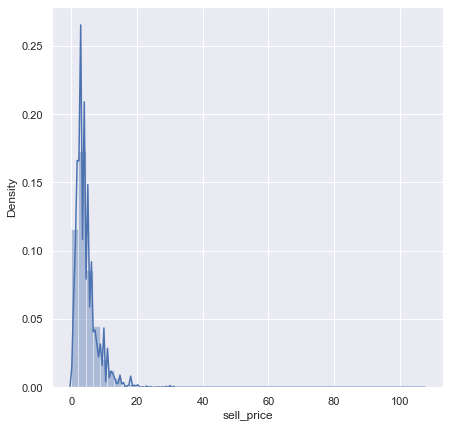

In [46]:
# To check the distibution of the "sell_price" column

sns.set()
plt.figure(figsize= (7,7))
sns.distplot(prices_df['sell_price'])
plt.show()

###### Key Observations:
- No missing value found in item prices dataframe
- Data is highly right skewed
    - Highest selling price of an item in the data available is 107.3 
    - 3.42 is the 50th percentile i.e, the mean selling price of the items sold
    - Lowest selling price of an item in data is 0.01

#### 3. Product Sales Dataframe

In [47]:
# first 2 rows of the dataframe
sales_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [48]:
# shape of the dataset
print("no. of rows in the sales_df dataset are {0} and no. of columns are {1}".format(sales_df.shape[0],sales_df.shape[1]))

no. of rows in the sales_df dataset are 30490 and no. of columns are 1947


In [49]:
# basic information about the features and dataset provided
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1317), int8(624)
memory usage: 96.3 MB


###### Key Observations:
- 6 categorial feaures

In [50]:
# Basic statistics about the sales data 
sales_df.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.445490,1.781174,1.965267,1.389374,1.271794,1.216661,1.212299,1.395605,1.689669,1.782158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.656824,4.426550,4.706284,3.313292,3.126178,3.000348,2.955910,3.514318,4.089208,4.284356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,143.000000,156.000000,187.000000,98.000000,90.000000,77.000000,84.000000,110.000000,156.000000,117.000000


##### Key Observation: 
- From seeing the stats we can interpret that the data is highly skewed
    - 75 percentile of values are less than 0
    - Mean for almost all day is close to 1 and median (50 %) is 0 --> Right Skewed
- Min value is 0 and max is around 436, which means that some items were bought in bulk for that day

In [51]:
# Basic information about the dataset provided
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1317), int8(624)
memory usage: 96.3 MB


##### Key Observation:
- Dataset has total 1947 features
    - In which 1941 are days which contains sales of product with integer data type
    - And 6 have categorical/object data type which are attributes

In [52]:
# exploring unique categories in each feature
categories = ['state_id','store_id','cat_id','dept_id']
for cat in categories:
    print("Unique values in {0}: {1}".format(cat,sales_df[cat].astype('object').unique()))

Unique values in state_id: ['CA' 'TX' 'WI']
Unique values in store_id: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
Unique values in cat_id: ['HOBBIES' 'HOUSEHOLD' 'FOODS']
Unique values in dept_id: ['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']


In [53]:
# number of unique values in each feature
print("no. of unique values in id: ",sales_df['id'].nunique())
print("no. of unique values in item_id: ",sales_df['item_id'].nunique())
print("no. of unique values in dept_id: ",sales_df['dept_id'].nunique())
print("no. of unique values in cat_id: ",sales_df['cat_id'].nunique())
print("no. of unique values in store_id: ",sales_df['store_id'].nunique())
print("no. of unique values in state_id: ",sales_df['state_id'].nunique())

no. of unique values in id:  30490
no. of unique values in item_id:  3049
no. of unique values in dept_id:  7
no. of unique values in cat_id:  3
no. of unique values in store_id:  10
no. of unique values in state_id:  3


##### Key Observations:
- In the data there are 3 states, 3 categories, 7 departments, 10 stores and 3049 items.
- 3 States : California (CA), Texas (TX), Wisconsin (WI)
- 10 stores 
- 3 Product categoris: Hobbies, Household and Food
- 7 sub-category of products/ departments
- 3049 items total
- 30490 items in 10 stores total where each store contains 3049 items (3049*10 = 30490) for 1941 days data

In [54]:
# checking number of missing values in each feature
    
print("no. of null values in feature id : ",sales_df['id'].isnull().sum())
print("no. of null values in feature item_id : ",sales_df['item_id'].isnull().sum())
print("no. of null values in feature dept_id : ",sales_df['dept_id'].isnull().sum())
print("no. of null values in feature cat_id : ",sales_df['cat_id'].isnull().sum())
print("no. of null values in feature store_id : ",sales_df['store_id'].isnull().sum())
print("no. of null values in feature state_id : ",sales_df['state_id'].isnull().sum())

no. of null values in feature id :  0
no. of null values in feature item_id :  0
no. of null values in feature dept_id :  0
no. of null values in feature cat_id :  0
no. of null values in feature store_id :  0
no. of null values in feature state_id :  0


##### Let's explore more about the number of items sold - EDA on the basis of QUANTITY

In [55]:
# We have data about number of quantity sold in columns d_1 - d_1941
# storing all sales column in a list d_columns = [d_1,d_2....d_1941]

d_columns = []
for column in sales_df.columns:
    if 'd_' in column:
        d_columns.append(column)
        
# print(d_columns[:5])
# print(len(d_columns))


In [56]:
# creating a a new feature 'total_sales' which stores total sales for each datapoint
# axis=1 will sum up across the rows 
sales_df['total_sales'] = sales_df[d_columns].sum(axis =1)
# print(sales_df['total_sales'])

###### Total sales - state wise

In [57]:
# Display the total sales for each state
# https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html

sales_df.groupby('state_id',as_index=False,sort=False).agg(total_sales=('total_sales',np.sum))


,state_id,total_sales
0,CA,29196717
1,TX,19228405
2,WI,18502051


In [58]:
# Display the sales percentage for each state
sales_df.groupby('state_id').agg(total_sales=('total_sales',np.sum))/ (sales_df['total_sales'].sum())*100

,total_sales
state_id,
CA,43.624608
TX,28.730341
WI,27.645051


###### Key Observations:
- In USA:
    - California being highest population (37,999,878 approx) has highest item sales proportion, approx 43.62%
    - Texas being second highest (26,060,796 approx) has 28.73% of sales proportion
    - Wisconsin has lowest population (5,724,554 approx) has 27.64% of sales
- total sales in california is high but population is also hign in california.surprisingly wisconsin having less population as compare to texas but still they have similar total sale.

###### Total sales - store wise

In [59]:
#Total-sales---store-wise# Display the total sales for each store
# refer: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
sales_df.groupby('store_id',as_index=False,sort=False).agg(total_sales=('total_sales',np.sum))

,store_id,total_sales
0,CA_1,7832248
1,CA_2,5818395
2,CA_3,11363540
3,CA_4,4182534
4,TX_1,5692823
5,TX_2,7329642
6,TX_3,6205940
7,WI_1,5261506
8,WI_2,6697988
9,WI_3,6542557


###### Key Observations:
- In California: CA_3 has sold maximum items while CA_4 has sold least number of items
- In Texas: TX_2 has sold max items while TX_1 has sold least number of items
- In Wisconsin: WI_2 has sold max number of items while WI_1 has sold least number of items

###### Total sales - Category wise

In [60]:
# Display the total sales for each category
sales = sales_df.groupby('cat_id',as_index=False,sort=False).agg(total_sales=('total_sales',np.sum))

In [61]:
# Display the sales percentage for each category
sales_df.groupby('cat_id').agg(total_sales=('total_sales',np.sum))/sales_df['total_sales'].sum()*100

,total_sales
cat_id,
FOODS,68.615519
HOBBIES,9.324547
HOUSEHOLD,22.059934


In [62]:
# https://plotly.com/python/pie-charts/
fig = px.pie(sales, values="total_sales", names="cat_id", title="Sales proportion- category wise")
fig.update_layout(width=800, height=400)
fig.show()

###### Key Observations:
- Foods category has highest item sales proportion, 68.61%
- Household has second highest, approx 22.1%
- Hobbies has least, 9.32%

###### Total sales - Department wise

In [63]:
# Display the total sales for each department
sales_df.groupby('dept_id',as_index=False,sort=False).agg(total_sales=('total_sales',np.sum))

,dept_id,total_sales
0,HOBBIES_1,5699014
1,HOBBIES_2,541642
2,HOUSEHOLD_1,11722853
3,HOUSEHOLD_2,3041237
4,FOODS_1,5190400
5,FOODS_2,7795025
6,FOODS_3,32937002


In [64]:
# Display the sales percentage for each department
sales_df.groupby('dept_id').agg(total_sales=('total_sales',np.sum))/sales_df['total_sales'].sum()*100

,total_sales
dept_id,
FOODS_1,7.755295
FOODS_2,11.647026
FOODS_3,49.213198
HOBBIES_1,8.515247
HOBBIES_2,0.809301
HOUSEHOLD_1,17.515835
HOUSEHOLD_2,4.544099


###### Key Observations:
- People tend to purchase more food than the other categories because food is necessity to survive.

##### Total sales - state and category wise

In [65]:
# Display the total sales of diff product category in each state
sales_df.groupby(['state_id','cat_id'],as_index=False,sort=False).agg(total_sales=('total_sales',np.sum))

,state_id,cat_id,total_sales
0,CA,HOBBIES,3095587
1,CA,HOUSEHOLD,6565267
2,CA,FOODS,19535863
3,TX,HOBBIES,1624130
4,TX,HOUSEHOLD,4432169
5,TX,FOODS,13172106
6,WI,HOBBIES,1520939
7,WI,HOUSEHOLD,3766654
8,WI,FOODS,13214458


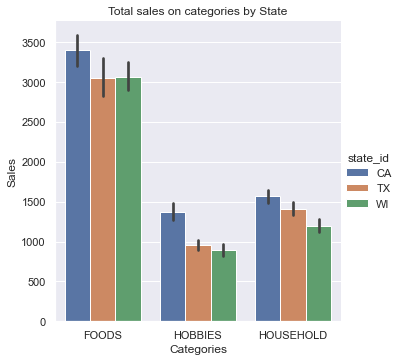

In [66]:
# Plot for total sales on categories by state
sns.catplot(x='cat_id', y='total_sales',
           hue = 'state_id',
            data = sales_df, kind = 'bar', height=5, aspect = 1)
plt.title('Total sales on categories by State')
plt.xlabel('Categories')
plt.ylabel('Sales')
plt.show()

###### Key Observations:
- For CA, TX and WI - Food has highest sales proportion, hobbies has lowest


#### Time Series of Total sales by category (all years)

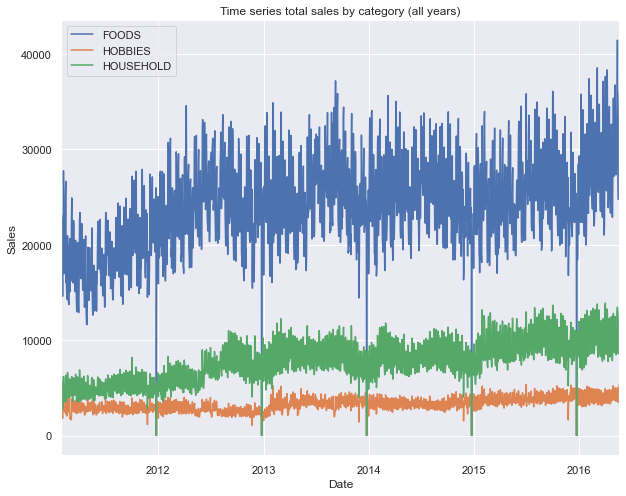

In [67]:
# Time Series of Total sales by category (all years)
# https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.merge.html

cat_sales = sales_df.groupby('cat_id')[d_columns].sum()
cat_sales = cat_sales.T.merge(calendar_df.set_index('d')['date'],
                                                   left_index = True,
                                                   right_index = True,
                                                   validate = '1:1')
cat_sales = cat_sales.set_index('date')

cat_sales.plot(kind='line', figsize=(10,8))
plt.title("Time series total sales by category (all years)")
plt.xlabel('Date',size = 12)
plt.ylabel('Sales',size =12)
plt.show()

###### Key Observations:
- First thing we observe is the pattern, for each year it is showing some parttern in sales
- There are many days in a year where sales goes to zero drastically, this could be due to some holiday when stores are closed for that particular day
- Sales are increasing year by year 
    - For Foods and Household: sales increasing over the years
    - For Hobbies: sales remain constant over the years


In [68]:
# creating a dataframe which shows total sum of sales id wise
total_item_id = sales_df.groupby('id').agg(total_sales=('total_sales',np.sum)).reset_index().sort_values('total_sales', ascending=False)
# Top 10 item id sold
total_item_id.head(10)

,id,total_sales
7022,FOODS_3_090_CA_3_evaluation,253859
11985,FOODS_3_586_TX_2_evaluation,195120
11986,FOODS_3_586_TX_3_evaluation,151862
11982,FOODS_3_586_CA_3_evaluation,136269
7020,FOODS_3_090_CA_1_evaluation,128855
7029,FOODS_3_090_WI_3_evaluation,123500
7025,FOODS_3_090_TX_2_evaluation,121275
7026,FOODS_3_090_TX_3_evaluation,116773
8645,FOODS_3_252_TX_2_evaluation,115613
11984,FOODS_3_586_TX_1_evaluation,114010


###### Key Observations:
- FOODS_3_090_CA_3_evaluation has the highest sales

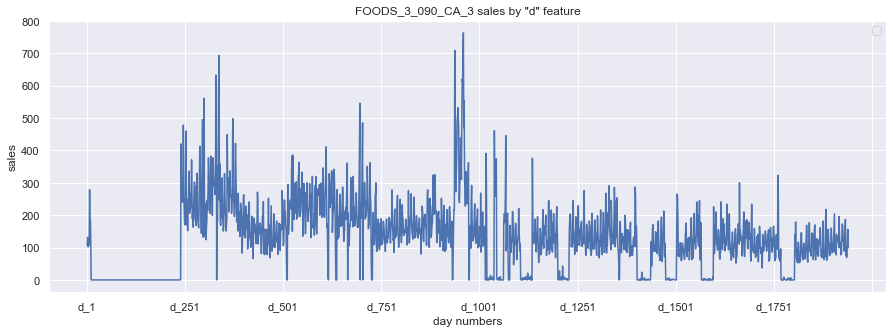

In [69]:
# to analyse further, let's visualize the YTD sales data for this single item - FOODS_3_090_CA_3
# d_columns contains list of all the column names, d_1 to d_1941

sample_id = sales_df.loc[sales_df['id'] == 'FOODS_3_090_CA_3_evaluation']
sample_id = sample_id.set_index('id')[d_columns].T

sample_id.plot(figsize = (15,5), title = 'FOODS_3_090_CA_3 sales by "d" feature')
plt.xlabel("day numbers")
plt.ylabel('sales')
plt.legend('')
plt.show()

###### Key Observations:
- We have long period of consecutive days where we have no sales for this particular item id
- This could be due to stock is finished or limited shelves area in shelves

In [70]:
# Creating variables to check the day where sales was zero
# grouping product category, state id wise

foods_state = sales_df.loc[(sales_df['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T
foods_state = foods_state.rename({'CA': 'FOODS_CA', 'TX': 'FOODS_TX', 'WI': 'FOODS_WI'}, axis=1)

household_state = sales_df.loc[(sales_df['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).mean().T
household_state = household_state.rename({'CA': 'HOUSEHOLD_CA', 'TX': 'HOUSEHOLD_TX', 'WI': 'HOUSEHOLD_WI'}, axis=1)

hobbies_state = sales_df.loc[(sales_df['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T
hobbies_state = hobbies_state.rename({'CA': 'HOBBIES_CA', 'TX': 'HOBBIES_TX', 'WI': 'HOBBIES_WI'}, axis=1)

cat_state_wise = pd.concat([ foods_state, hobbies_state, household_state,], axis=1)
# cat_state_wise = cat_state_wise.drop('total_sales')

In [71]:
cat_state_wise.loc[cat_state_wise['HOUSEHOLD_CA'] == 0]

state_id,FOODS_CA,FOODS_TX,FOODS_WI,HOBBIES_CA,HOBBIES_TX,HOBBIES_WI,HOUSEHOLD_CA,HOUSEHOLD_TX,HOUSEHOLD_WI
d_331,0.001392,0.000464,0.000696,0.0,0.0,0.0,0.0,0.0,0.000000
d_697,0.001044,0.000464,0.000696,0.0,0.0,0.0,0.0,0.0,0.000000
d_1062,0.000870,0.003016,0.000464,0.0,0.0,0.0,0.0,0.0,0.000000
d_1427,0.001044,0.003016,0.000232,0.0,0.0,0.0,0.0,0.0,0.000000
d_1792,0.001044,0.000928,0.000696,0.0,0.0,0.0,0.0,0.0,0.000318


In [72]:
calendar_df.loc[calendar_df['d'].isin(['d_331', 'd_697', 'd_1062', 'd_1427', 'd_1792'])]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,no_event,no_event,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,no_event,no_event,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,no_event,no_event,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,no_event,no_event,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,no_event,no_event,0,0,0


###### Key Observations:
- Some special events like Christmas affects the sales in every state, where there is no sales and sales was zero
- only product belong to food category had some sale in Christmas

## 5.  Pre-processing

In [73]:
# let's drop total sales column from the sales files
sales_df = sales_df.drop('total_sales',axis=1)
# sales_df.head(3)

### a. Melting the data
- Coverting the data from wide format to long format 
- This helps us to pose our problem into exact regression problem



In [74]:
# %%time
# # https://www.geeksforgeeks.org/python-pandas-melt/#:~:text=melt()%20function%20is%20useful,identifier%20columns%2C%20variable%20and%20value.
# # https://pandas.pydata.org/docs/reference/api/pandas.melt.html
# # since we need to have days as particular columns I have modified train_evaluation.csv and assigned changed structure of it
# # I have created 2 column: d for day and quantity sold which contains sales for that day
# # This would increase the size of the file drastically



# sales_melt = pd.melt(sales_df, id_vars =['id', 'item_id','dept_id','cat_id','store_id','state_id'],
#                      var_name = 'd', value_name='quantity sold').dropna()


###### Key Observations:
- It took around 34 mins to melt the sales data

In [75]:
# sales_melt.info()

###### Key Observations:
- Memory usage has increased to 1.4 GB
- For sales_df it was 96.3 MB

In [76]:
# %%time
# # storing sales data to pickel file for future refrence
# sales_melt.to_pickle('sales_data.pkl')


In [77]:
%%time 

#reading from pickle
sales_data = pd.read_pickle('sales_data.pkl')


Wall time: 8.27 s


In [78]:
sales_data.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d,quantity sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


### b. Merging the data

In [79]:
# Using dask dataframe to avoid RAM crashing
import dask.dataframe as dd # similar to pandas

In [80]:
%%time
# merging calendar dataframe with sales_data
ddf = dd.merge(sales_data, calendar_df, on = 'd', how = 'left')
# merging sell_price dataframe within our final_df
final_ddf = dd.merge(ddf, prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')

Wall time: 11min 5s


- It took approx 7min minutes to merge all the dataframe


In [81]:
final_ddf.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,quantity sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,NaN


In [82]:
final_ddf.tail(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,quantity sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,...,5,2016,no_event,no_event,no_event,no_event,0,0,0,3.980469
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,no_event,no_event,no_event,no_event,0,0,0,1.280273
59181089,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,...,5,2016,no_event,no_event,no_event,no_event,0,0,0,1.000000


###### Key Observations:
- We have lots of null value for sell price

In [83]:
final_ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             category      
 1   item_id        category      
 2   dept_id        category      
 3   cat_id         category      
 4   store_id       category      
 5   state_id       category      
 6   d              object        
 7   quantity sold  int16         
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  weekday        category      
 11  wday           int8          
 12  month          int8          
 13  year           int16         
 14  event_name_1   category      
 15  event_type_1   category      
 16  event_name_2   category      
 17  event_type_2   category      
 18  snap_CA        int8          
 19  snap_TX        int8          
 20  snap_WI        int8          
 21  sell_price     float16       
dtypes: category(11), datetime64[ns](1), floa

###### Key Observations:
- Memory usage has increased alot now, 2.8 GB approx
- We have all the features now in a single dataframe

In [84]:
len(final_ddf)

59181090

In [85]:
type(final_ddf)

pandas.core.frame.DataFrame

In [86]:
# # converting dask dataframe to pandas

# final_df = final_ddf.compute()
# type(final_df)

In [87]:
# %%time
# final_ddf.to_pickle('final_df.pkl')

In [88]:
final_df = pd.read_pickle('final_df.pkl')

## Let's now do some EDA on the whole dataframe

###### final_df  
    - consists all three dataframes: calendar_df  + sales_df + prices_df

In [89]:
final_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,quantity sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,NaN


In [90]:
final_df.isna().sum()

id                      0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
quantity sold           0
date                    0
wm_yr_wk                0
weekday                 0
wday                    0
month                   0
year                    0
event_name_1            0
event_type_1            0
event_name_2            0
event_type_2            0
snap_CA                 0
snap_TX                 0
snap_WI                 0
sell_price       12299413
dtype: int64

###### Observation:
- Out of 59M datapoints we have 12M rows/datapoints where sell_price have Null value

###### Handling missing values - Mean Imputation

In [91]:
# filling the missing values in "sell_price" column with "Mean" value
# with respect to its store because price may vary based on store

final_df['sell_price'].fillna(final_df.groupby(['store_id','item_id'])['sell_price'].transform('mean'),
                              inplace=True)

In [92]:
final_df.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d,quantity sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,8.281250
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,3.970703
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,2.970703
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,4.527344
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,2.943359
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.990723
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,7.882812
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.459961
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,1.559570
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,no_event,no_event,no_event,no_event,0,0,0,3.169922


In [93]:
final_df.shape

(59181090, 22)

In [94]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             category      
 1   item_id        category      
 2   dept_id        category      
 3   cat_id         category      
 4   store_id       category      
 5   state_id       category      
 6   d              object        
 7   quantity sold  int16         
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  weekday        category      
 11  wday           int8          
 12  month          int8          
 13  year           int16         
 14  event_name_1   category      
 15  event_type_1   category      
 16  event_name_2   category      
 17  event_type_2   category      
 18  snap_CA        int8          
 19  snap_TX        int8          
 20  snap_WI        int8          
 21  sell_price     float16       
dtypes: category(11), datetime64[ns](1), floa

#### Clearly this DataFrame is using a lot memory (2.8+ GB) even after downcasting the data, so we will try to remove unnecessary features and will try to reduce size of the dataframe while doing Feature Engineering

In [95]:
#just to cross verify if we have all the values present in our final df 
# comparing quantities sold in final_df with our previous analysis done on sales_df dataframe

final_df.groupby(['dept_id'], as_index=False, sort=False).agg(total_sales=('quantity sold',np.sum))

,dept_id,total_sales
0,HOBBIES_1,5699014.0
1,HOBBIES_2,541642.0
2,HOUSEHOLD_1,11722853.0
3,HOUSEHOLD_2,3041237.0
4,FOODS_1,5190400.0
5,FOODS_2,7795025.0
6,FOODS_3,32937002.0


###### Key Observations:
- sales quantities are matching with previous analysis

###### Let's analyse quantities sold based on:  calendar_df features

###### total sales - month wise

In [96]:
sales =final_df.groupby(['month'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.sum))
sales

,month,total_sales
0,1,5345511.0
1,2,5889589.0
2,3,6387210.0
3,4,6197793.0
4,5,6033079.0
5,6,5250212.0
6,7,5443975.0
7,8,5571730.0
8,9,5321889.0
9,10,5380589.0


In [97]:
# let's create a new feature which have month names corresponding to month 

sales['month_name'] = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
sales

,month,total_sales,month_name
0,1,5345511.0,Jan
1,2,5889589.0,Feb
2,3,6387210.0,Mar
3,4,6197793.0,Apr
4,5,6033079.0,May
5,6,5250212.0,June
6,7,5443975.0,July
7,8,5571730.0,Aug
8,9,5321889.0,Sep
9,10,5380589.0,Oct


In [98]:
# https://plotly.com/python/bar-charts/

fig = px.bar(sales, x="month_name", y="total_sales", color="month_name", title="total sales - month wise",text_auto=True)
fig.update_layout(width=800, height=400)
fig.show()

###### Key Observations:
- Sales in the month of February, March, April and May is high as compare to other months among all years

###### Total sales - weekday wise

In [99]:
# now let's do some analysis of sales based on weekday
sales = final_df.groupby(['weekday'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.sum))
sales

,weekday,total_sales
0,Saturday,11594343.0
1,Sunday,11482526.0
2,Monday,9139596.0
3,Tuesday,8448634.0
4,Wednesday,8346126.0
5,Thursday,8398928.0
6,Friday,9517020.0


In [100]:
fig= px.bar(sales, x="weekday", y="total_sales", color="weekday", title="Sales - weekday wise", text_auto=True)
fig.update_layout(width=800, height=400)
fig.show()

###### Key Observations:
- Sales are high on weekends including friday
- rest of the day sales are normal

###### total sales - event type 1 wise

In [101]:
# Sales based on event type 1
# data = final_df.groupby(['event_type_1'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.sum))
# since the distribution of the data is very skewed so we will use mean 

sales = final_df.groupby(['event_type_1'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.mean))
sales

,event_type_1,total_sales
0,no_event,1.135105
1,Sporting,1.174026
2,Cultural,1.138688
3,National,0.966170
4,Religious,1.129099


In [102]:
#plotly bar chart

fig= px.bar(sales, x="event_type_1", y="total_sales", color="event_type_1", title="Sales - event type 1 wise",text_auto=True)
fig.update_layout(width=800, height=400)
fig.show()

###### Key Observations:
- For event type 1 mean sales are high on events as compared to no events specially if there is an event related to sports
- For days having National event mean sales are lower comparatively

In [103]:
sales = final_df.groupby(['event_name_1'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.mean))
sales

,event_name_1,total_sales
0,no_event,1.135105
1,SuperBowl,1.342211
2,ValentinesDay,1.098579
3,PresidentsDay,1.129758
4,LentStart,1.007773
5,LentWeek2,0.975631
6,StPatricksDay,1.097398
7,Purim End,1.179305
8,OrthodoxEaster,1.352181
9,Pesach End,1.189898


In [104]:
fig = px.bar(sales, x="event_name_1", y="total_sales", color="event_name_1", title="Sales - Event name 1 wise",text_auto=True)
fig.update_layout(width=1000, height=500)
fig.show()

###### Key Observations:
- We can see some sale happen on Christmas also, this is for food as analyzed before
- Sales on event laborDay is highest
- We can say that there is impact of Events on sales

###### total sales - event type 2

In [105]:
sales = final_df.groupby(['event_type_2'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.mean))
sales

,event_type_2,total_sales
0,no_event,1.130706
1,Cultural,1.199464
2,Religious,1.276943


In [106]:
fig = px.bar(sales, x="event_type_2", y="total_sales", color="event_type_2", title="Sales - event type 2 wise", text_auto=True)
fig.update_layout(width=800, height=400)
fig.show()

###### Key Observations:
- Average sales are maximum when we have 2 events of Religious and Cultural type.


In [107]:
sales = final_df.groupby(['event_name_2'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.mean))
sales

,event_name_2,total_sales
0,no_event,1.130706
1,Easter,0.787734
2,Cinco De Mayo,1.416956
3,OrthodoxEaster,1.276943
4,Father's day,1.393703


In [108]:
fig = px.bar(sales, x="event_name_2", y="total_sales", color="event_name_2", title="Sales - event name 2 wise",text_auto=True)
fig.update_layout(width=800, height=400)
fig.show()

###### Key Observations:
- Sales get impacted according to event type.
- Cinco De Mayo event has highest mean sales
- Easter has lowest mean sales

###### total sales - SNAP vs Non SNAP 
- 0 indicates Non SNAP
- 1 indicates SNAP

###### California

In [109]:
# selecting datapoints with state id = CA
CA_sales = final_df[final_df['state_id']=='CA'][['snap_CA','quantity sold']]

In [110]:
sales = CA_sales.groupby(['snap_CA'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.sum))
sales

,snap_CA,total_sales
0,0,19069726.0
1,1,10126991.0


###### Texas

In [111]:
# selecting datapoints with state id = TX
TX_sales = final_df[final_df['state_id']=='TX'][['snap_TX','quantity sold']]

In [112]:
sales = TX_sales.groupby(['snap_TX'],as_index=False,sort=False).agg(total_sales=('quantity sold',np.sum))
sales

,snap_TX,total_sales
0,0,12416557.0
1,1,6811848.0


###### Wisconsin

In [113]:
# selecting datapoints with state id = WI
WI_sales = final_df[final_df['state_id']=='WI'][['snap_WI','quantity sold']]

In [114]:
sales = WI_sales.groupby(['snap_WI'],as_index = False, sort=False).agg(total_sales=('quantity sold',np.sum))
sales

,snap_WI,total_sales
0,0,11569147.0
1,1,6932904.0


###### Key Observations:
- Sales in all the three states during the Non-Snap days are higher than sales in Snap days.

#### Analysis based on sales price

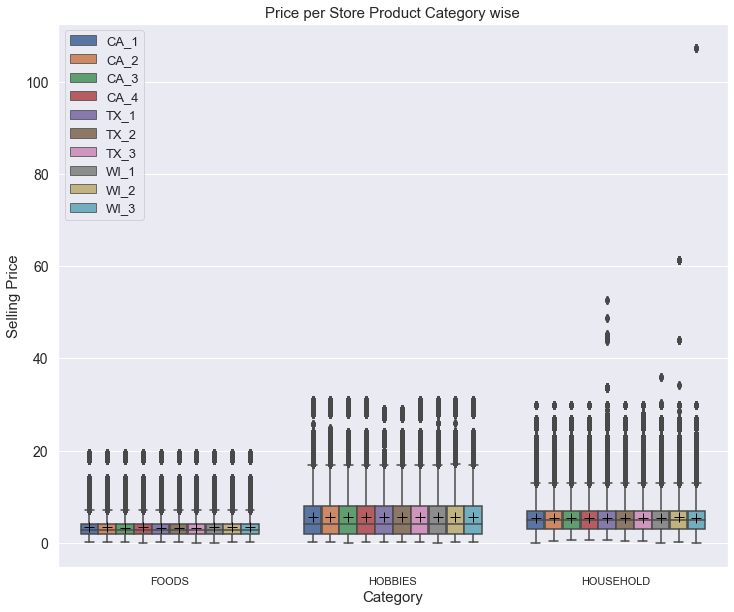

In [115]:
#https://www.geeksforgeeks.org/how-to-show-mean-on-boxplot-using-seaborn-in-python/

price_dist =final_df[['cat_id','store_id','sell_price']]
fig,ax= plt.subplots(figsize=(12,10))

sns.boxplot(x='cat_id',y='sell_price',data=price_dist ,showmeans=True,
            meanprops={"marker": "+","markeredgecolor": "black","markersize": "10"},hue='store_id')

ax.set_title('Price per Store Product Category wise',fontsize=15)
ax.set_xlabel('Category',fontsize=15)
ax.set_ylabel('Selling Price',fontsize=15)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
plt.show()

##### Key Observations:

- FOODS : Sell price is almost same for every store and lowest among all categories.
- HOBBIES : Sell price is same for every store and higher than FOODS category.
- HOUSEHOLD : Sell price is highest among all categories and sometimes sell price goes very high (more than 100)

###### Conclusion:
1. We have reduced in memory usage of our data by using downcasting, approx 76% 
2. After analysing the sales in each state and store we come to know that there is a pattern in sales and it is increasing slightly every year
3. State wise: 
    - California being highest population has highest item sales proportion, approx 43.62%
    - Texas and Wisconsin has almost same sales proportion, approx 28%
4. Sales are highest for FOODS, approx 68.61%
5. Sales are lowest for HOBBIES
5. Sales are high on weekend i.e, Saturday and Sunday
6. Average sales are high on events as compared to no events specially if there is an event related to sports
7. Sales get affected due to special events like Christmas in every state, where there is no sales on such event
7. Sales in the month of February, March, April and May is high as compare to other months among all years
8. Sell price of Household items are highest among all categories and sometimes sell price goes very high (more than 100)

